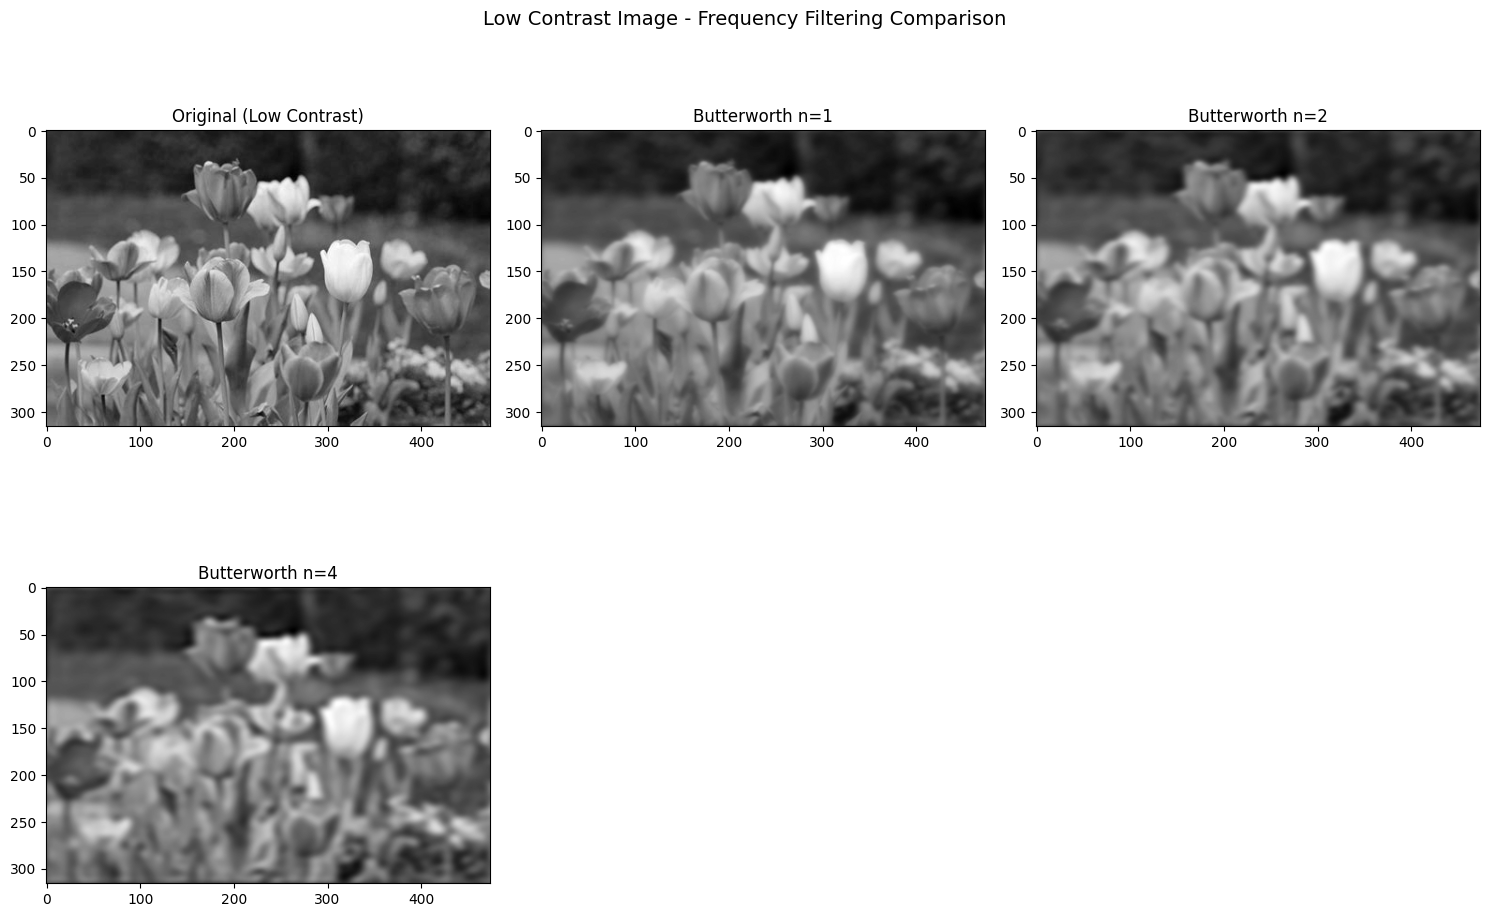

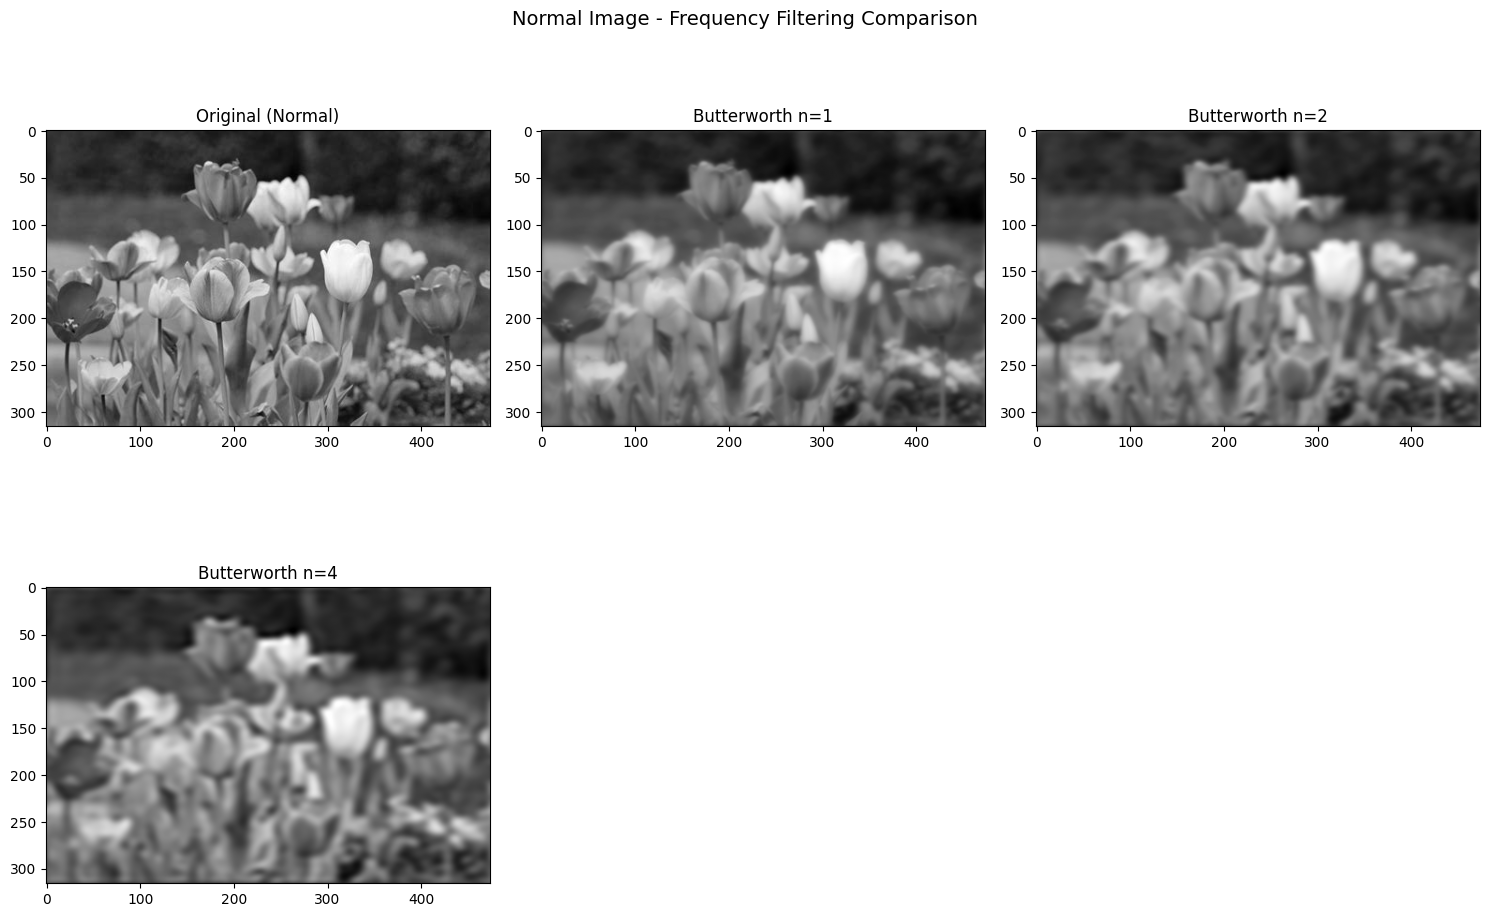

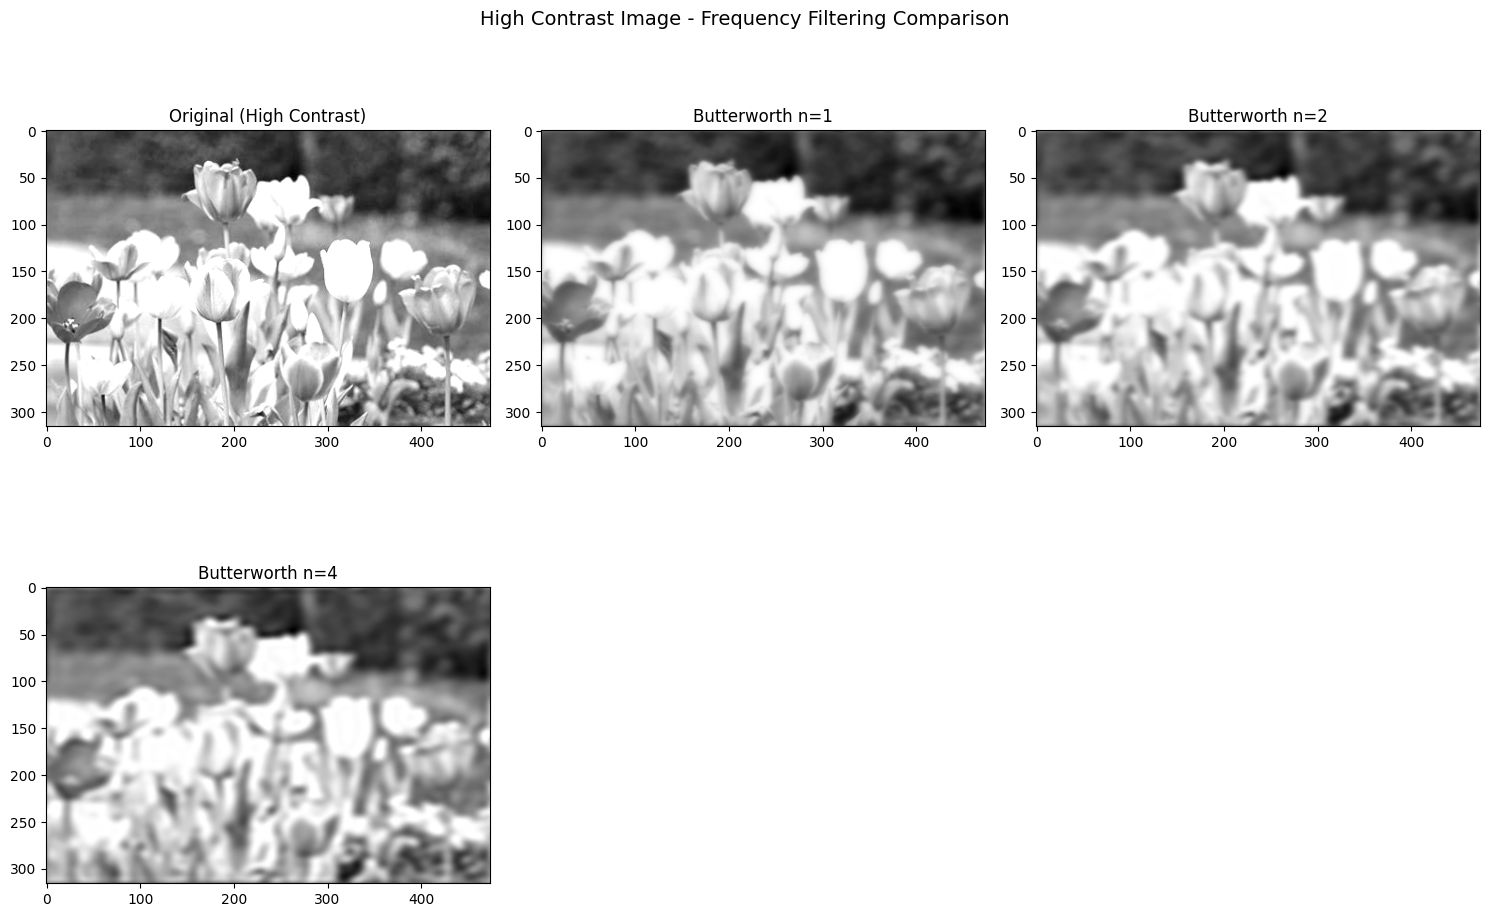

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# -----------------------------
# Utility Functions
# -----------------------------
def contrast_adjust(img, alpha, beta):
    """Adjust contrast using: new_img = alpha*img + beta"""
    new_img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
    return new_img

def fft_image(img):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    return fshift

def ifft_image(fshift):
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    return img_back

def distance_matrix(shape):
    M, N = shape
    u = np.arange(M) - M//2
    v = np.arange(N) - N//2
    V, U = np.meshgrid(v, u)
    D = np.sqrt(U**2 + V**2)
    return D

# -----------------------------
# Filter Generators
# -----------------------------
def ideal_filter(shape, D0, type='low', D1=None):
    D = distance_matrix(shape)
    if type == 'low':
        H = np.double(D <= D0)
    elif type == 'high':
        H = np.double(D > D0)
    elif type == 'band':
        H = np.double((D > D1) & (D < D0))
    return H

def butterworth_filter(shape, D0, n=2, type='low', D1=None):
    D = distance_matrix(shape)
    if type == 'low':
        H = 1 / (1 + (D / D0)**(2*n))
    elif type == 'high':
        H = 1 / (1 + (D0 / D)**(2*n))
    elif type == 'band':
        H = 1 / (1 + (D * D / ((D*D - D0*D1)**2 + 1e-6)))  # Simplified band version
    return H

def gaussian_filter(shape, D0, type='low', D1=None):
    D = distance_matrix(shape)
    if type == 'low':
        H = np.exp(-(D**2) / (2*(D0**2)))
    elif type == 'high':
        H = 1 - np.exp(-(D**2) / (2*(D0**2)))
    elif type == 'band':
        H = np.exp(-(D**2 - ((D0 + D1)/2)**2) / (2*((D0 - D1)**2)))
    return H

# -----------------------------
# Filtering Operation
# -----------------------------
def apply_filter(img, H):
    fshift = fft_image(img)
    filtered = fshift * H
    result = ifft_image(filtered)
    return np.uint8(np.clip(result, 0, 255))

# -----------------------------
# Main Experiment
# -----------------------------
# Load and prepare images

cwd = os.getcwd()
cwds = cwd.split('/')
cwds.pop(-1)
img_path = '/'.join(cwds[:-1]) + f'/image/tulip.jpeg'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

low_contrast = contrast_adjust(img, 0.5, 20)
normal_contrast = img.copy()
high_contrast = contrast_adjust(img, 1.5, 20)

images = {'Low Contrast': low_contrast, 'Normal': normal_contrast, 'High Contrast': high_contrast}

D0 = 30  # Cutoff frequency
orders = [1, 2, 4]

for key, im in images.items():
    plt.figure(figsize=(15, 10))
    plt.suptitle(f'{key} Image - Frequency Filtering Comparison', fontsize=14)
    
    # Filters
    H_ideal = ideal_filter(im.shape, D0, 'low')
    H_butter = butterworth_filter(im.shape, D0, n=2, type='low')
    H_gauss = gaussian_filter(im.shape, D0, 'low')

    ideal_result = apply_filter(im, H_ideal)
    butter_result = apply_filter(im, H_butter)
    gauss_result = apply_filter(im, H_gauss)

    # Display
    plt.subplot(2,3,1); plt.imshow(im, cmap='gray'); plt.title(f'Original ({key})')
    plt.subplot(2,3,2); plt.imshow(ideal_result, cmap='gray'); plt.title('Ideal LPF')
    plt.subplot(2,3,3); plt.imshow(butter_result, cmap='gray'); plt.title('Butterworth LPF')
    plt.subplot(2,3,4); plt.imshow(gauss_result, cmap='gray'); plt.title('Gaussian LPF')

    # Different 'n' in Butterworth
    for n in orders:
        H_butter_n = butterworth_filter(im.shape, D0, n=n, type='low')
        res = apply_filter(im, H_butter_n)
        plt.subplot(2,3,orders.index(n)+2)
        plt.imshow(res, cmap='gray')
        plt.title(f'Butterworth n={n}')
    
    plt.tight_layout()
    plt.show()


Original Frequency Domain Energies (All Images):
| Image Variant | Low Band | Mid Band | High Band |
|---------------|----------|----------|-----------|
| **Image 1** | | | |
| Low         |   7.18 |   7.03 |   7.03 |
| Normal      |   7.87 |   7.72 |   7.72 |
| High        |   8.22 |   8.11 |   8.12 |
| **Image 2** | | | |
| Low         |   7.04 |   7.01 |   7.03 |
| Normal      |   7.73 |   7.70 |   7.73 |
| High        |   8.24 |   8.10 |   8.09 |
| **Image 3** | | | |
| Low         |   7.19 |   7.02 |   7.05 |
| Normal      |   7.88 |   7.71 |   7.74 |
| High        |   8.30 |   8.10 |   8.14 |
| **Image 4** | | | |
| Low         |   7.11 |   7.04 |   7.01 |
| Normal      |   7.80 |   7.74 |   7.71 |
| High        |   8.28 |   8.09 |   8.11 |
| **Image 5** | | | |
| Low         |   7.14 |   7.05 |   7.04 |
| Normal      |   7.83 |   7.74 |   7.73 |
| High        |   8.17 |   8.14 |   8.11 |

Post-Filtering Energies for Gaussian Filters (Image 1):
| Filter / Variant | Low Band | Mid

/tmp/ipykernel_40305/2977812187.py:107: RuntimeWarning: divide by zero encountered in divide
  H = 1 / (1 + (D0 / r)**(2 * n))
/tmp/ipykernel_40305/2977812187.py:110: RuntimeWarning: divide by zero encountered in divide
  H_hp = 1 / (1 + (D1 / r)**(2 * n))


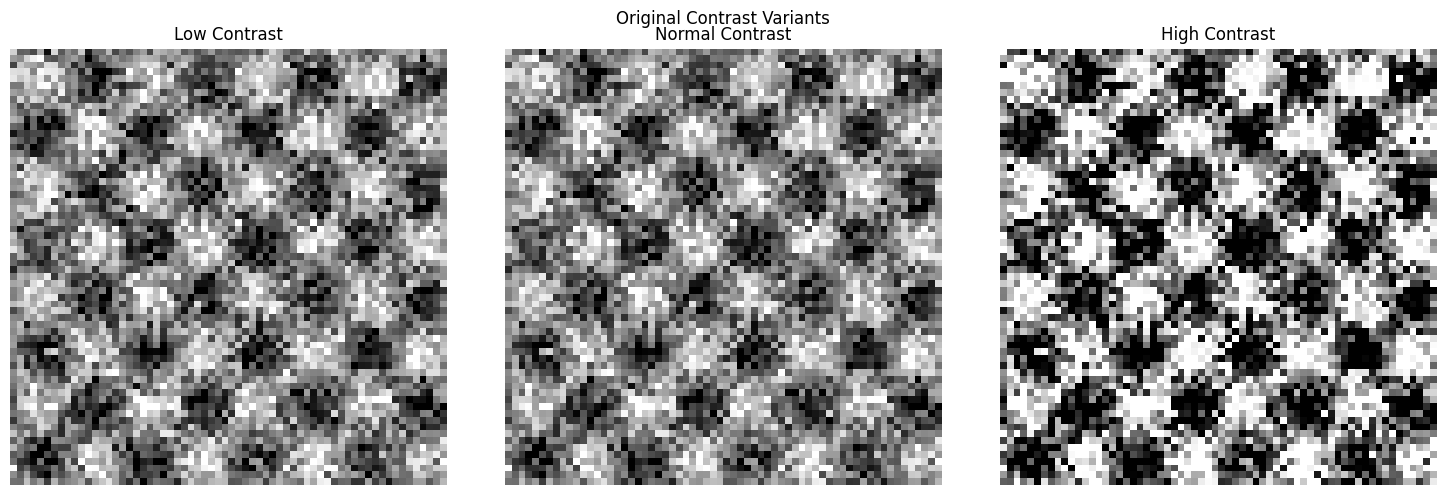

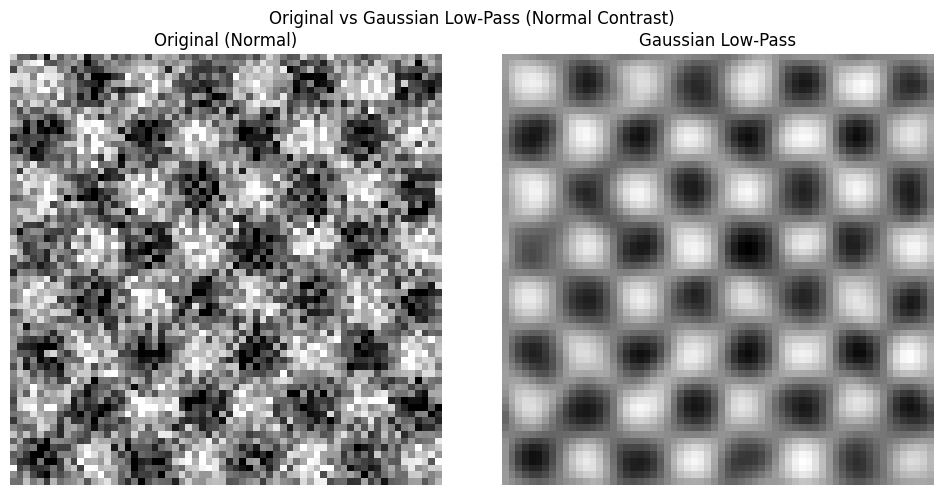

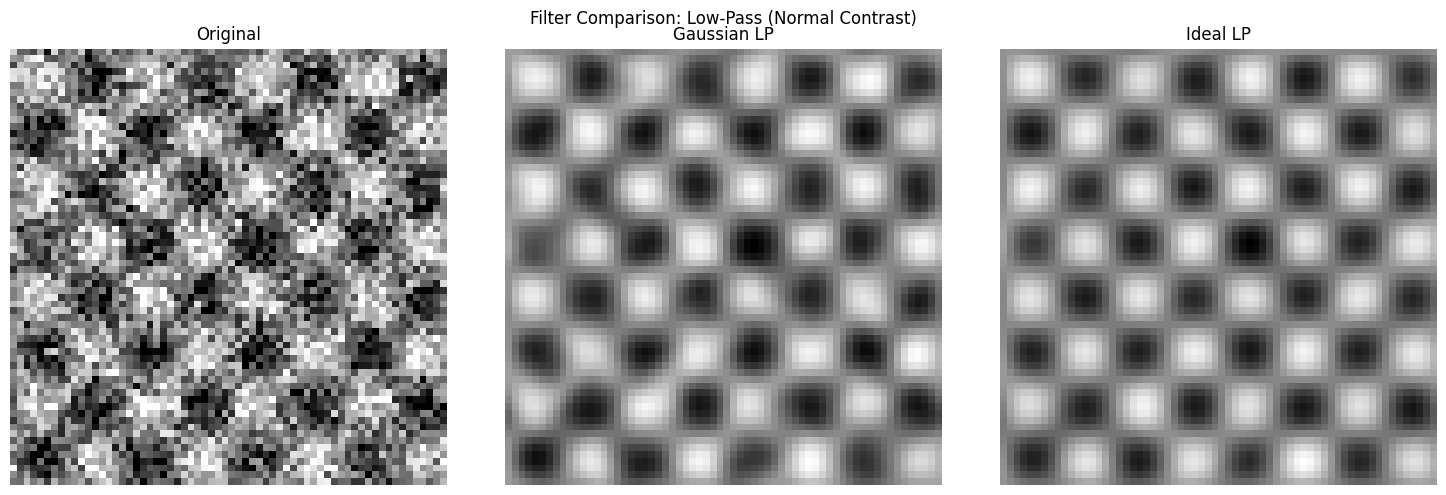

In [5]:
import numpy as np
from scipy.fft import fft2, fftshift, ifft2, ifftshift
import matplotlib.pyplot as plt

def generate_base_image(seed, size=64):
    """
    Generate a synthetic 64x64 grayscale image: sine wave + Gaussian noise.
    """
    np.random.seed(seed)
    x, y = np.meshgrid(np.arange(size), np.arange(size))
    
    # Low-frequency sine wave (period ~16 pixels)
    low_freq = 128 + 100 * np.sin(2 * np.pi * x / 16) * np.sin(2 * np.pi * y / 16)
    
    # High-frequency Gaussian noise (sigma=50)
    noise = np.random.normal(0, 50, (size, size))
    
    image = low_freq + noise
    return np.clip(image, 0, 255).astype(np.uint8)

def adjust_contrast(image, factor):
    """
    Adjust contrast linearly around mean intensity.
    """
    mean = np.mean(image)
    adjusted = mean + factor * (image - mean)
    return np.clip(adjusted, 0, 255).astype(np.uint8)

def compute_band_energies(F_shifted):
    """
    Compute log-magnitude energies in radial bands from shifted FFT.
    Bands: low (r <=8), mid (8 < r <=24), high (r >24)
    """
    magnitude = np.log(np.abs(F_shifted) + 1)
    size = F_shifted.shape[0]
    center = size // 2
    y, x = np.ogrid[:size, :size]
    r = np.sqrt((x - center)**2 + (y - center)**2)
    
    # Band masks
    low_mask = r <= 8
    mid_mask = (r > 8) & (r <= 24)
    high_mask = r > 24
    
    # Mean log-magnitude in each band
    low_energy = np.mean(magnitude[low_mask]) if np.any(low_mask) else 0
    mid_energy = np.mean(magnitude[mid_mask]) if np.any(mid_mask) else 0
    high_energy = np.mean(magnitude[high_mask]) if np.any(high_mask) else 0
    
    return low_energy, mid_energy, high_energy

def apply_ideal_filter(F_shifted, filter_type, size):
    """
    Apply ideal low-pass, high-pass, or band-pass filter.
    Cutoffs: low-pass r<=6.4, high-pass r>6.4, band-pass 3.2-9.6
    """
    center = size // 2
    y, x = np.ogrid[:size, :size]
    r = np.sqrt((x - center)**2 + (y - center)**2)
    
    if filter_type == 'low_pass':
        mask = r <= 6.4
    elif filter_type == 'high_pass':
        mask = r > 6.4
    elif filter_type == 'band_pass':
        mask = (r >= 3.2) & (r <= 9.6)
    else:
        raise ValueError("Invalid filter type")
    
    F_filtered = F_shifted.copy()
    F_filtered[~mask] = 0
    return F_filtered

def apply_gaussian_filter(F_shifted, filter_type, size, D0=6.4, D1=3.2, D2=9.6):
    """
    Apply Gaussian low-pass, high-pass, or band-pass filter.
    """
    center = size // 2
    y, x = np.ogrid[:size, :size]
    r = np.sqrt((x - center)**2 + (y - center)**2)
    
    if filter_type == 'low_pass':
        H = np.exp( - r**2 / (2 * D0**2) )
    elif filter_type == 'high_pass':
        H = 1 - np.exp( - r**2 / (2 * D0**2) )
    elif filter_type == 'band_pass':
        H_lp = np.exp( - r**2 / (2 * D2**2) )
        H_hp = 1 - np.exp( - r**2 / (2 * D1**2) )
        H = H_lp * H_hp
    else:
        raise ValueError("Invalid filter type")
    
    F_filtered = F_shifted * H
    return F_filtered

def apply_butterworth_filter(F_shifted, filter_type, size, n=2, D0=6.4, D1=3.2, D2=9.6):
    """
    Apply Butterworth low-pass, high-pass, or band-pass filter.
    """
    center = size // 2
    y, x = np.ogrid[:size, :size]
    r = np.sqrt((x - center)**2 + (y - center)**2)
    
    if filter_type == 'low_pass':
        H = 1 / (1 + (r / D0)**(2 * n))
    elif filter_type == 'high_pass':
        H = 1 / (1 + (D0 / r)**(2 * n))
    elif filter_type == 'band_pass':
        H_lp = 1 / (1 + (r / D2)**(2 * n))
        H_hp = 1 / (1 + (D1 / r)**(2 * n))
        H = H_lp * H_hp
    else:
        raise ValueError("Invalid filter type")
    
    F_filtered = F_shifted * H
    return F_filtered

def plot_images(images_dict, title="Image Comparison", cmap='gray'):
    """
    Plot multiple images in a grid using matplotlib.
    images_dict: dict of {label: image_array}
    """
    fig, axes = plt.subplots(1, len(images_dict), figsize=(5 * len(images_dict), 5))
    if len(images_dict) == 1:
        axes = [axes]
    
    for idx, (label, img) in enumerate(images_dict.items()):
        axes[idx].imshow(img, cmap=cmap)
        axes[idx].set_title(label)
        axes[idx].axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def main():
    """
    Main function to generate images, apply filters, print tables, and plot examples.
    """
    num_images = 5  # For completeness, though tables use Image 1
    contrasts = {'low': 0.5, 'normal': 1.0, 'high': 2.0}
    
    # Print original energies for all 5 images (as in prior report)
    print("Original Frequency Domain Energies (All Images):")
    print("| Image Variant | Low Band | Mid Band | High Band |")
    print("|---------------|----------|----------|-----------|")
    
    for img_idx in range(1, num_images + 1):
        seed = img_idx
        base = generate_base_image(seed)
        print(f"| **Image {img_idx}** | | | |")
        for contrast_name, factor in contrasts.items():
            variant = adjust_contrast(base, factor)
            F_shifted = fftshift(fft2(variant))
            low_e, mid_e, high_e = compute_band_energies(F_shifted)
            print(f"| {contrast_name.capitalize():<11} | {low_e:6.2f} | {mid_e:6.2f} | {high_e:6.2f} |")
    
    # Filtering tables (Image 1)
    seed = 1
    base = generate_base_image(seed)
    
    print("\nPost-Filtering Energies for Gaussian Filters (Image 1):")
    print("| Filter / Variant | Low Band | Mid Band | High Band |")
    print("|------------------|----------|----------|-----------|")
    
    for contrast_name, factor in contrasts.items():
        variant = adjust_contrast(base, factor)
        F_shifted = fftshift(fft2(variant))
        orig_low, orig_mid, orig_high = compute_band_energies(F_shifted)
        
        print(f"| **{contrast_name.capitalize()}-Contrast** | | | |")
        print(f"| Original         | {orig_low:6.2f} | {orig_mid:6.2f} | {orig_high:6.2f} |")
        
        for filter_type in ['low_pass', 'high_pass', 'band_pass']:
            F_filtered = apply_gaussian_filter(F_shifted, filter_type, variant.shape[0])
            low_e, mid_e, high_e = compute_band_energies(F_filtered)
            print(f"| Gaussian-{filter_type.replace('_', '-').title()} | {low_e:6.2f} | {mid_e:6.2f} | {high_e:6.2f} |")
    
    print("\nPost-Filtering Energies for Butterworth Filters (n=2, Image 1):")
    print("| Filter / Variant | Low Band | Mid Band | High Band |")
    print("|------------------|----------|----------|-----------|")
    
    for contrast_name, factor in contrasts.items():
        variant = adjust_contrast(base, factor)
        F_shifted = fftshift(fft2(variant))
        orig_low, orig_mid, orig_high = compute_band_energies(F_shifted)
        
        print(f"| **{contrast_name.capitalize()}-Contrast** | | | |")
        print(f"| Original         | {orig_low:6.2f} | {orig_mid:6.2f} | {orig_high:6.2f} |")
        
        for filter_type in ['low_pass', 'high_pass', 'band_pass']:
            F_filtered = apply_butterworth_filter(F_shifted, filter_type, variant.shape[0], n=2)
            low_e, mid_e, high_e = compute_band_energies(F_filtered)
            print(f"| Butterworth-{filter_type.replace('_', '-').title()} | {low_e:6.2f} | {mid_e:6.2f} | {high_e:6.2f} |")
    
    print("\nButterworth Low-Pass with Varying n (Normal Contrast, Image 1):")
    print("| n Value | Low Band | Mid Band | High Band |")
    print("|---------|----------|----------|-----------|")
    
    variant = adjust_contrast(base, 1.0)
    F_shifted = fftshift(fft2(variant))
    orig_low, orig_mid, orig_high = compute_band_energies(F_shifted)
    print(f"| Original | {orig_low:6.2f} | {orig_mid:6.2f} | {orig_high:6.2f} |")
    
    for n in [1, 2, 4]:
        F_filtered = apply_butterworth_filter(F_shifted, 'low_pass', variant.shape[0], n=n)
        low_e, mid_e, high_e = compute_band_energies(F_filtered)
        print(f"| n={n}     | {low_e:6.2f} | {mid_e:6.2f} | {high_e:6.2f} |")
    
    print("\nPost-Filtering Energies for Ideal Filters (Image 1):")
    print("| Filter / Variant | Low Band | Mid Band | High Band |")
    print("|------------------|----------|----------|-----------|")
    
    for contrast_name, factor in contrasts.items():
        variant = adjust_contrast(base, factor)
        F_shifted = fftshift(fft2(variant))
        orig_low, orig_mid, orig_high = compute_band_energies(F_shifted)
        
        print(f"| **{contrast_name.capitalize()}-Contrast** | | | |")
        print(f"| Original         | {orig_low:6.2f} | {orig_mid:6.2f} | {orig_high:6.2f} |")
        
        for filter_type in ['low_pass', 'high_pass', 'band_pass']:
            F_filtered = apply_ideal_filter(F_shifted, filter_type, variant.shape[0])
            low_e, mid_e, high_e = compute_band_energies(F_filtered)
            print(f"| Ideal-{filter_type.replace('_', '-').title()} | {low_e:6.2f} | {mid_e:6.2f} | {high_e:6.2f} |")
    
    # Plotting examples: Original contrast variants and some filtered versions (Normal contrast)
    print("\nGenerating plots...")
    
    # Original contrasts
    images_original = {
        'Low Contrast': adjust_contrast(base, 0.5),
        'Normal Contrast': adjust_contrast(base, 1.0),
        'High Contrast': adjust_contrast(base, 2.0)
    }
    plot_images(images_original, "Original Contrast Variants")
    
    # Example: Gaussian low-pass on normal contrast (to spatial domain)
    variant_normal = adjust_contrast(base, 1.0)
    F_shifted = fftshift(fft2(variant_normal))
    F_gaussian_lp = apply_gaussian_filter(F_shifted, 'low_pass', variant_normal.shape[0])
    spatial_gaussian_lp = np.abs(ifft2(ifftshift(F_gaussian_lp)))
    spatial_gaussian_lp = np.clip(spatial_gaussian_lp, 0, 255).astype(np.uint8)
    
    images_filtered = {
        'Original (Normal)': variant_normal,
        'Gaussian Low-Pass': spatial_gaussian_lp
    }
    plot_images(images_filtered, "Original vs Gaussian Low-Pass (Normal Contrast)")
    
    # Add more plots as needed, e.g., for Butterworth or ideal
    F_ideal_lp = apply_ideal_filter(F_shifted, 'low_pass', variant_normal.shape[0])
    spatial_ideal_lp = np.abs(ifft2(ifftshift(F_ideal_lp)))
    spatial_ideal_lp = np.clip(spatial_ideal_lp, 0, 255).astype(np.uint8)
    
    images_comparison = {
        'Original': variant_normal,
        'Gaussian LP': spatial_gaussian_lp,
        'Ideal LP': spatial_ideal_lp
    }
    plot_images(images_comparison, "Filter Comparison: Low-Pass (Normal Contrast)")

if __name__ == "__main__":
    main()